## Dataset Information 
The breast cancer histopathological image dataset (BreakHis) contains **9109** microscopic images of breast tumor tissues collected from **82** patients, regarded as malignant or benign. The tissues are magnigfied at different scaling factors (**40X**, **100X**, **200X**, **400X**). In this dataset, it contains **2480** malignant and **5429** benign tumors. The images of tissues are taken to be **700X460 pixels**, **3-channel RGB**, **8** bit depth in each format, and in PNG. It is believed that this dataset can become a benchmark for future classifications of breast cancer classification.        

In [1]:
# importing libraries

import warnings
warnings.filterwarnings('ignore')

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, time, tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import *
import tensorflow as tf 
from functools import partial
# import keras
from tensorflow.keras import layers
import albumentations as A
import tensorflow_hub as hub
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import KFold

In [2]:
!nvidia-smi

'nvidia-smi' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
image_dir = 'D:/VIT Pune/2. Second Year/SY Sem 2/EDI/final/BreaKHis_v1/'
data_path = 'D:/VIT Pune/2. Second Year/SY Sem 2/EDI/final/Folds.csv'

# experimental API for making data pipelines
tf.data.experimental.AUTOTUNE

# defining the class names
class_names = ['malignant', 'benign']
print(class_names)

['malignant', 'benign']


In [4]:
# loading the data
data = pd.read_csv(data_path)
data.head(5)

,fold,mag,grp,filename
0,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
1,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
2,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
3,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
4,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...


In [5]:
data['fold'].value_counts()

1    7909
2    7909
3    7909
4    7909
5    7909
Name: fold, dtype: int64

In [6]:
# renaming and structuring the columns for better data understanding
data = data.rename(columns={'filename': 'path'})
data['label'] = data.path.apply(lambda x: x.split('/')[3])
data['label_int'] = data.label.apply(lambda x: class_names.index(x))
data['filename'] = data.path.apply(lambda x: x.split('/')[-1])

In [7]:
# view first n rows of strucrured data
data.head(6)

,fold,mag,grp,path,label,label_int,filename
0,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_A-14-22549AB-100-001.png
1,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_A-14-22549AB-100-002.png
2,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_A-14-22549AB-100-003.png
3,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_A-14-22549AB-100-004.png
4,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_A-14-22549AB-100-005.png
5,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_A-14-22549AB-100-006.png


In [8]:
data.shape

(39545, 7)

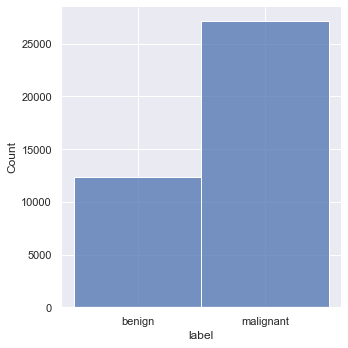

In [9]:
# making a plot to see data distribution
# sns.figure()
sns.set_theme()
sns.displot(x='label', data=data)

<AxesSubplot:xlabel='label', ylabel='count'>

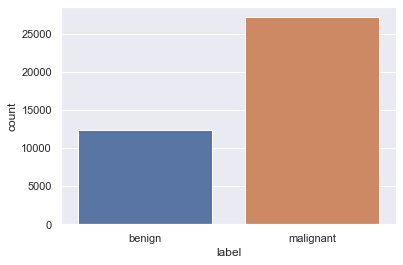

In [10]:
sns.countplot(x=data['label'], data=data)

In [11]:
# sorting out training, validation and testing images
test_images = data.groupby(by='label').sample(3000)
train_images = data.drop(test_images.index).reset_index(drop=True)
test_images = test_images.reset_index(drop=True)

In [12]:
# making splits of training & validation datasets
validation_images = train_images.sample(frac = 0.3)
train_images = train_images.drop(validation_images.index).reset_index(drop=True)
validation_images = validation_images.reset_index(drop=True)

In [13]:
print('Total training images: % s' % str(train_images.shape[0]))
print('Total validation images: % s' % str(validation_images.shape[0]))
print('Total testing images: % s' % str(test_images.shape[0]))

Total training images: 23481
Total validation images: 10064
Total testing images: 6000


In [14]:
train_images['set'] = 'train'
validation_images['set'] = 'validation'
test_images['set'] = 'test'

In [15]:
new_data = pd.concat([train_images, validation_images, test_images])
new_data.head(5)

,fold,mag,grp,path,label,label_int,filename,set
0,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_A-14-22549AB-100-001.png,train
1,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_A-14-22549AB-100-002.png,train
2,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_A-14-22549AB-100-003.png,train
3,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_A-14-22549AB-100-006.png,train
4,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_A-14-22549AB-100-008.png,train


### Visualizing Train, Validation & Test Splits

<AxesSubplot:xlabel='label', ylabel='count'>

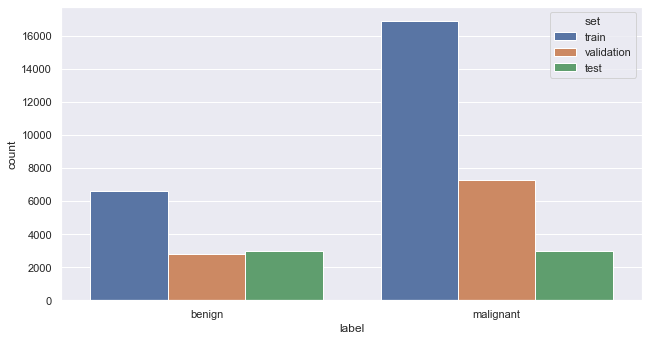

In [16]:
sns.set(rc={'figure.figsize':(10.4, 5.4)})
sns.countplot(x=new_data['label'], hue=new_data['set'])

## Unsampling Data

In [17]:
max_count = np.max(train_images.label.value_counts())
min_count = np.min(train_images.label.value_counts())
train_images = train_images.groupby('label').sample(n=max_count, replace=True)
train_images = train_images.reset_index(drop=True)

In [18]:
train_images.head(5)

,fold,mag,grp,path,label,label_int,filename,set
0,5,200,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_A-14-29960CD-200-008.png,train
1,5,100,test,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_F-14-9133-100-003.png,train
2,1,40,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_TA-14-16184CD-40-008.png,train
3,2,200,test,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_PT-14-29315EF-200-003.png,train
4,2,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_TA-14-21978AB-100-007.png,train


## Making the Deep Learning Model

In [19]:
model_handle_map = {"efficientnetv2-b0": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2", 
                   "inception_v3": "https://tfhub.dev/google/imagenet/inception_v3/feature_vector/4", 
                   "inception_resnet_v2": "https://tfhub.dev/google/imagenet/inception_resnet_v2/feature-vector/4"}
model_image_size = {"efficientnetv2-b0": 224, 
                   "inception_v3": 299, 
                   "inception_resnet_v2": 299}

In [20]:
# function to decode a PNG image into a tf tensor
def load_image(path, label):
    image = tf.io.read_file(path)
    image = tf.io.decode_png(image, channels=3)
    return image, label

# reshaping the image between 0 and 1
def image_reshape(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [224, 224] / 255)
    return image, label

# image argumentation for faster model training
def argument_image(image):
    transform = A.Compose([A.HorizontalFlip(p = 0.5), 
                          A.Rotate(p = 0.5, limit = 15), 
                          A.RandomBrightnessContrast(p=0.5, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.1, 0.1), 
                                                    brightness_by_max=True),
                           A.RandomResizedCrop(p=0.8, height=IMG_SIZE, width=IMG_SIZE, 
                                              scale=(0.9, 1.1), ratio=(0.05, 1.1), interpolation=0),
                           A.Blur(blur_limit = (1, 1))
                           
                          ])
    
    data = {"image": image}
    argumented_data = transform(**data)
    argumented_image = argumented_data["image"]
    argumented_image = tf.cast(argumented_image, tf.float32)
    argumented_image = tf.image.resize(argumented_image, [IMG_SIZE, IMG_SIZE]) / 255
    
    return argumented_image

def argumentor_function(image, label):
    argumented_image = tf.numpy_function(func = argument_image, inp=[image], Tout = tf.float32)
    return argumented_image, label


# function to view sample of images
def view_image(ds, col = 5, row = 5, size=(30, 10)):
    plt.figure(figsize=(10, 5))
    plt.subplots_adjust(wspace = 0.05, hspace = 0.15)
    for images, labels in ds.take(1):
        for i in range(col * row):
            ax = plt.subplot(row, col, i + 1)
            shape = str(images[i].numpy().shape)
            plt.imshow(images[i].numpy())
            plt.title(class_names[labels[i].numpy()])
            plt.axis("off") 
    plt.tight_layout
    return None

def view_model_predictions():
    plt.figure(figsize = (30, 8))
    plt.rcParams.update({'font.size': 10})
    plt.subplots_adjust(wspace = 0.05, hspace = 0.15)
    for i in range(30):
        ax = plt.subplot(3, 10, i + 1)
        shape = str(test_image[i].numpy().shape)
        plt.imshow(test_image[i].numpy())
        plt.title(predicted_label[i][0])
        plt.axis("off") 
        plt.tight_layout
    return None

# making a function to calculate & show model history
def model_hist(history):
    accuracy = history['accuracy']
    loss = history['loss']
    val_accuracy = history['val_accuracy']
    val_loss = history['val_loss']
    
    # setting the epochs
    n_epochs = range(len(history['loss']))
    
    # saving models logs
    # csv_logger = CSVLogger('cnn_model_logs.csv', append=True)
    
    # making plots for accuracy 
    plt.figure(figsize=(16, 5))
    plt.subplot(1, 2, 1)
    plt.plot(n_epochs, accuracy, label='training accuracy')
    plt.plot(n_epochs, val_accuracy, label='validation accuracy')
    plt.legend()
    
    # making plots for loss
    plt.figure(figsize=(16, 5))
    plt.subplot(1, 2, 2)
    plt.plot(n_epochs, loss, label='training loss (binary crossentropy)')
    plt.plot(n_epochs, val_loss, label='validation loss (binary crossentropy)')
    plt.legend()
    
    return None

# function for decoding a test image
def decode_test_img(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [224, 224])
    return image

# function for building a NN
def make_nn_model(image_size):
    print('Making our deep cnn model.....')
    cnn_model = tf.keras.Sequential([
        layers.InputLayer(input_shape=(image_size, image_size, 3)),
        hub.KerasLayer(model_handle, trainable=True, name='base'),
        layers.Dense(512, activation='relu', name='fc1'),
        layers.BatchNormalization(),
        layers.Dropout(0.4, name='dropout'),
        layers.Dense(128, activation='relu', name='fc2'),
        layers.BatchNormalization(),
        # layers.Dropout(0.4, name='dropout2'),
        layers.Dense(1, activation='sigmoid', name='output')
    ], name=model_name)
    
    cnn_model.build((None, image_size, image_size, 3))
    cnn_model.summary()
    print('model built!')
    return cnn_model

### Model Configuration Parameters 

In [21]:
# defining model configuration parameters
model_name = "efficientnetv2-b0"
# model_name = "inception_v3"
# model_name = "inception_resnet_v2"
model_handle = model_handle_map.get(model_name)
IMG_SIZE = model_image_size.get(model_name, 224)
BATCH_SIZE = 32
EPOCHS = 10
sample_size = len(train_images)

print(f"Selected model: {model_name} : {model_handle}")
print(f"Input size of model: {IMG_SIZE}")

Selected model: efficientnetv2-b0 : https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2
Input size of model: 224


In [22]:
IMG_SIZE

224

In [23]:
(image_dir + train_images.path)[0]

'D:/VIT Pune/2. Second Year/SY Sem 2/EDI/final/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-29960CD/200X/SOB_B_A-14-29960CD-200-008.png'

In [24]:
# loading the train & validation dataets
load_train = tf.data.Dataset.from_tensor_slices((image_dir + train_images.path, 
                                                train_images.label_int))

load_valid = tf.data.Dataset.from_tensor_slices((image_dir + validation_images.path, 
                                                validation_images.label_int))

In [25]:
load_train

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [26]:
train_dataset = (
                load_train.shuffle(len(train_images))
                .map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                .map(partial(argumentor_function), num_parallel_calls=tf.data.experimental.AUTOTUNE)
                .batch(BATCH_SIZE)
                .prefetch(tf.data.experimental.AUTOTUNE)
                )
val_dataset = (
                load_valid.shuffle(len(validation_images))
                .map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                .map(partial(argumentor_function), num_parallel_calls=tf.data.experimental.AUTOTUNE)
                .batch(BATCH_SIZE)
                .prefetch(tf.data.experimental.AUTOTUNE)
                )

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [27]:
# checking the path of images
train_images.path[5]

'BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-3411F/100X/SOB_B_TA-14-3411F-100-010.png'

Time Taken: 2.633 seconds


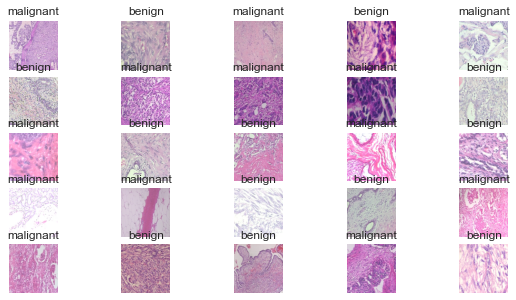

In [28]:
start = time.time()
view_image(train_dataset)
end = time.time()
print('Time Taken: %.3f seconds' % (end-start))

Time Taken: 2.271 seconds


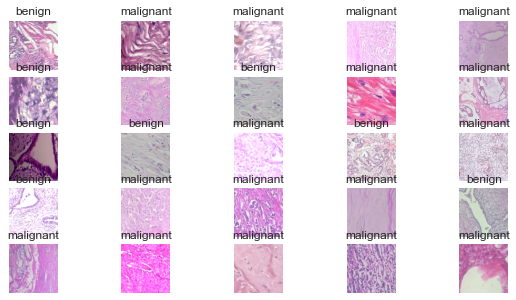

In [29]:
start = time.time()
view_image(val_dataset)
end = time.time()
print('Time Taken: %.3f seconds' % (end-start))

In [30]:
def get_labels_from_tfdataset(tfdataset, batched=False):

    labels = list(map(lambda x: x[1], tfdataset)) # Get labels 

    if not batched:
        return tf.concat(labels, axis=0) # concat the list of batched labels

    return labels
get_labels_from_tfdataset(train_dataset)

<tf.Tensor: shape=(33792,), dtype=int64, numpy=array([0, 0, 1, ..., 0, 1, 0], dtype=int64)>

In [31]:
print('Size of Image being used: %d' % (IMG_SIZE))

Size of Image being used: 224


In [32]:
# starting a new sesion for TF
image_size = 224
tf.keras.backend.clear_session()
model_nn = make_nn_model(IMG_SIZE)

# making model checkpoints
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', save_best_only=True)

# model logs
csv_logger = CSVLogger('cnn_model_logs.csv', append=True)

metrics = ['accuracy', Precision(name='Precision'), Recall(name='Recall')]

# compiling the model
model_nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=metrics)

# fit the model
train_history = model_nn.fit(train_dataset, epochs=5, batch_size=BATCH_SIZE, verbose=1,
                             callbacks=[model_checkpoint, csv_logger], validation_data=val_dataset)

Making our deep cnn model.....
Model: "efficientnetv2-b0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 base (KerasLayer)           (None, 1280)              5919312   
                                                                 
 fc1 (Dense)                 (None, 512)               655872    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 fc2 (Dense)                 (None, 128)               65664     
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)  

## Visualize Model Performance (Loss/Accuracy)

train_history.save()

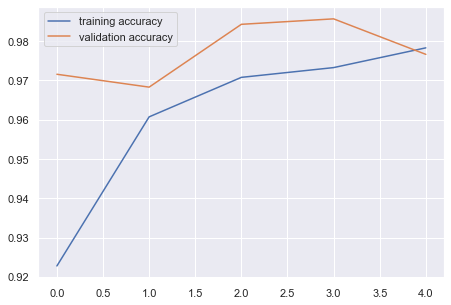

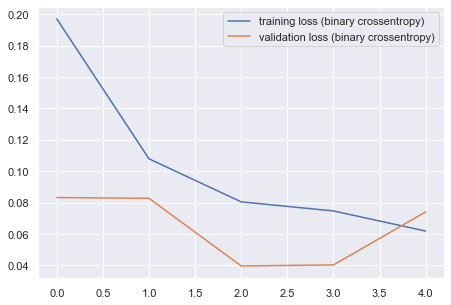

In [33]:
# visualize model performance
history = train_history.history
model_hist(history)

## 

In [34]:
model_performance = model_nn.evaluate(val_dataset)

315/315 [==============================] - 249s 791ms/step - loss: 0.0734 - accuracy: 0.9773 - Precision: 0.9865 - Recall: 0.9318


In [35]:
print('Net loss on validation data: %.3f' % model_performance[0])
print('Net accuracy on validation data: %.3f' % model_performance[1])
print('Net precision on validation data: %.3f' % model_performance[2])
print('Net recall on validation data: %.3f' % model_performance[3])

model_nn.save("kensar.h5")

Net loss on validation data: 0.073
Net accuracy on validation data: 0.977
Net precision on validation data: 0.986
Net recall on validation data: 0.932


## Evaluation on Test Data

In [36]:
# making samples of test data
test_images = test_images.sample(frac=1).reset_index(drop=True)
test_data = tf.data.Dataset.from_tensor_slices(image_dir + test_images.path)
test_data = test_data.map(decode_test_img, 
                          num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64)
test_data

<BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

In [37]:
print('Total Test Images: %d' % len(test_images))

Total Test Images: 6000


In [38]:
test_index = test_images.label_int.values
test_labels = test_images.label.values
test_index, test_labels

(array([0, 1, 1, ..., 1, 0, 0], dtype=int64),
 array(['malignant', 'benign', 'benign', ..., 'benign', 'malignant',
        'malignant'], dtype=object))

In [39]:
test_image = next(iter(test_data))

In [40]:
# making predictions
test_predictions = model_nn.predict(test_data)
predicted_index = np.round(test_predictions)

In [41]:
# checking predictions made by neural network
predicted_index[:6]

array([[1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.]], dtype=float32)

In [42]:
predicted_index = np.round(test_predictions).astype(int)
predicted_label = np.array(class_names)[predicted_index]
predicted_label[:8]

array([['benign'],
       ['benign'],
       ['malignant'],
       ['benign'],
       ['benign'],
       ['benign'],
       ['benign'],
       ['benign']], dtype='<U9')

In [43]:
prediction_data = pd.DataFrame({'filename':test_images.filename.values,'actual':test_images.label.values, 
                              'prediction': np.squeeze(predicted_label),'path':test_images.path.values,})

In [44]:
# see model predictions
prediction_data[['actual', 'prediction']].head(100)

,actual,prediction
0,malignant,benign
1,benign,benign
2,benign,malignant
3,malignant,benign
4,malignant,benign
...,...,...
95,benign,benign
96,malignant,benign
97,malignant,benign
98,malignant,benign
